In [1]:
#运行这个代码可以让Python不显示warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
#读取匹配后的GPS数据
BUS_GPS = pd.read_csv(r'D:\jiaotong\《交通大数据分析实战》课程资料\任务7：实战应用—公交GPS数据分析\上海公交GPS数据\bus_gps_matched.csv')
#读取公交线数据
shp = r'D:\jiaotong\《交通大数据分析实战》课程资料\任务7：实战应用—公交GPS数据分析\上海公交GPS数据\71_2017_line.json'
line = gpd.GeoDataFrame.from_file(shp,encoding = 'gbk')

#转换坐标系
line.crs = {'init':'epsg:4326'}
line = line.to_crs(epsg = 2416)

#取第一条数据里面的geometry
lineshp = line['geometry'].iloc[0]
linename = line['name'].iloc[0]

#读取公交站点数据
shp = r'D:\jiaotong\《交通大数据分析实战》课程资料\任务7：实战应用—公交GPS数据分析\上海公交GPS数据\71_2017_stop.json'
stop = gpd.GeoDataFrame.from_file(shp,encoding = 'gbk')

#转换坐标
stop.crs = {'init':'epsg:4326'}
stop = stop.to_crs(epsg = 2416)

#地图匹配
stop['project'] = stop['geometry'].apply(lambda r:lineshp.project(r))
stop = stop[stop['linename'] == linename]

#读取到离站信息
arrive_info = pd.read_csv(r'D:\jiaotong\《交通大数据分析实战》课程资料\任务7：实战应用—公交GPS数据分析\上海公交GPS数据\arrive_info.csv')


In [3]:
#单程耗时计算

In [4]:
#上行
#将起终点的信息提取后合并到一起
a = arrive_info[arrive_info['stopname'] == '延安东路外滩'][['arrivetime','stopname','carid']]
b = arrive_info[arrive_info['stopname'] == '申昆路枢纽站'][['leavetime','stopname','carid']]
a.columns = ['time','stopname','carid']
b.columns = ['time','stopname','carid']
c = pd.concat([a,b])

#排序后提取每一趟的出行时间
c = c.sort_values(by = ['carid','time'])
for i in c.columns:
    c[i+'1'] = c[i].shift(-1)
c = c[(c['carid'] == c['carid1'])&(c['stopname']=='申昆路枢纽站')&(c['stopname1']=='延安东路外滩')]
c['duration'] = c['time1'] - c['time']

#标识该趟出行在哪个小时
c['shour'] = ((c['time']+c['time1'])/7200).astype(int)
c['hue'] = '申昆路枢纽站-延安东路外滩'
c1 = c.copy()

In [5]:
#下行
#将起终点的信息提取后合并到一起
a = arrive_info[arrive_info['stopname'] == '申昆路枢纽站'][['arrivetime','stopname','carid']]
b = arrive_info[arrive_info['stopname'] == '延安东路外滩'][['leavetime','stopname','carid']]
a.columns = ['time','stopname','carid']
b.columns = ['time','stopname','carid']
c = pd.concat([a,b])

#排序后提取每一趟的出行时间
c = c.sort_values(by = ['carid','time'])
for i in c.columns:
    c[i+'1'] = c[i].shift(-1)
c = c[(c['carid'] == c['carid1'])&(c['stopname']=='延安东路外滩')&(c['stopname1']=='申昆路枢纽站')]
c['duration'] = c['time1'] - c['time']

#标识该趟出行在哪个小时
c['shour'] = ((c['time']+c['time1'])/7200).astype(int)
c['hue'] = '延安东路外滩-申昆路枢纽站'
c2 = c.copy()

In [6]:
#单程耗时的分布可视化和运行速度

In [7]:
c = pd.concat([c1,c2])

In [8]:
#绘制耗时分布箱型图

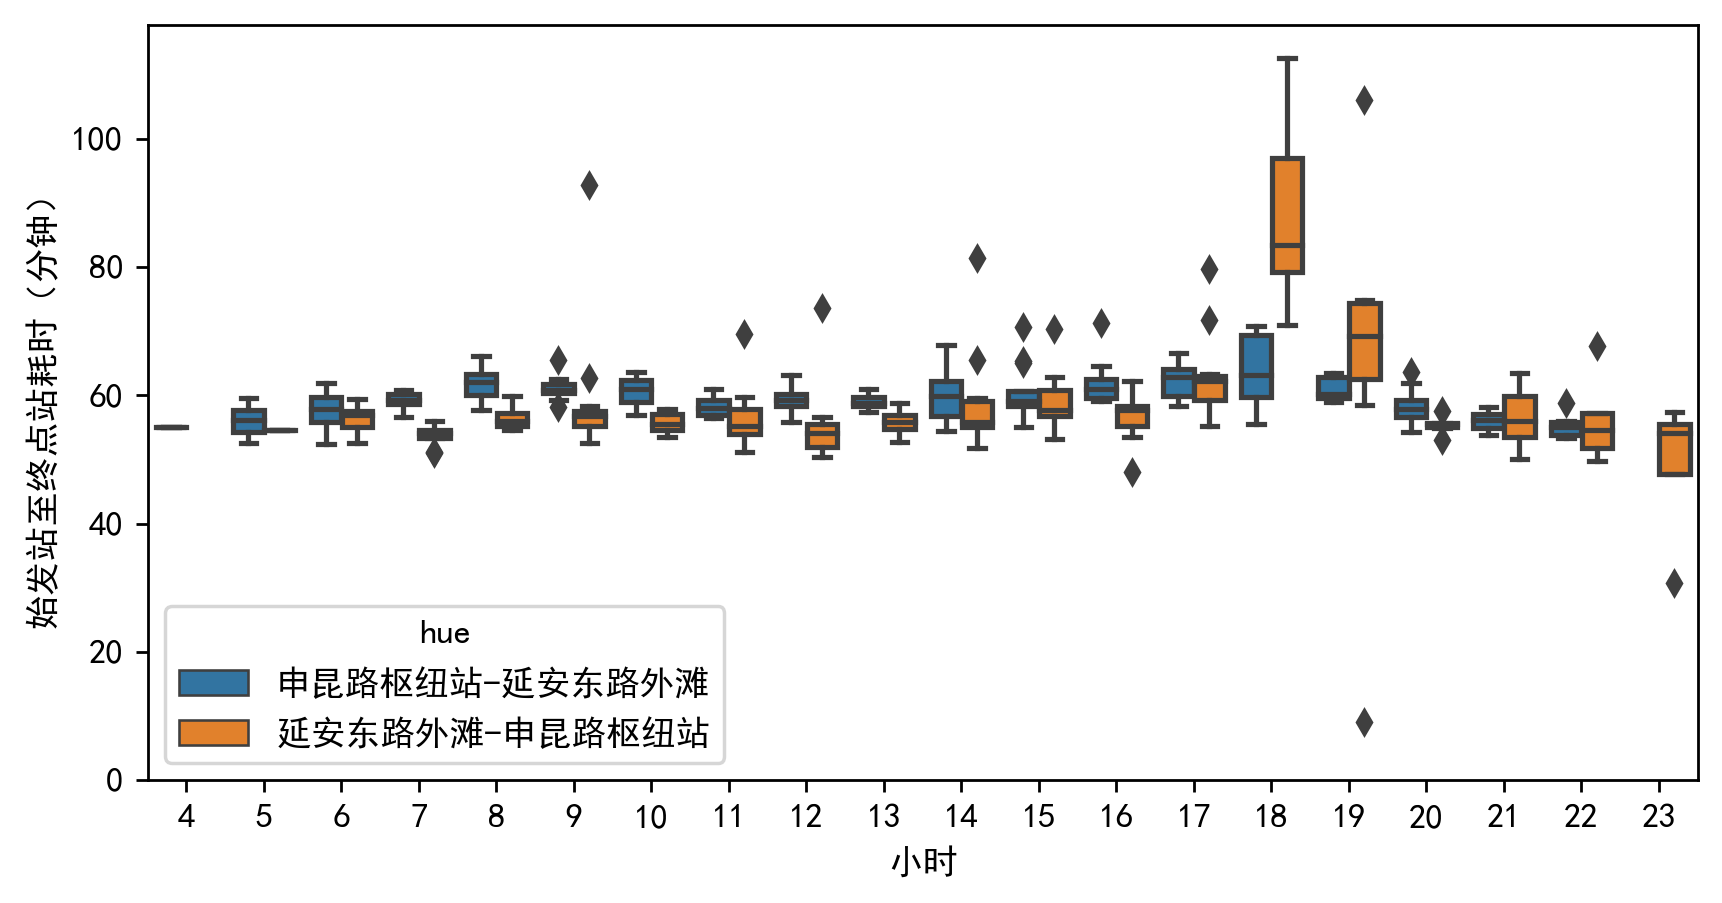

In [9]:
## 绘制耗时分布箱型图
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig     = plt.figure(1,(8,4),dpi = 250)    
ax1      = plt.subplot(111)

sns.boxplot(x = 'shour',y = c['duration']/60,hue = 'hue',data = c)

plt.ylabel('始发站至终点站耗时（分钟）')
plt.xlabel('小时')
plt.ylim(0)
plt.show()


In [10]:
#运营速度计算

In [11]:
#公交线的长度
lineshp.length

17512.985949554015

In [12]:
#筛选去掉车速过快的
c['speed'] = (lineshp.length/c['duration'])*3.6
c = c[c['speed']<=60]

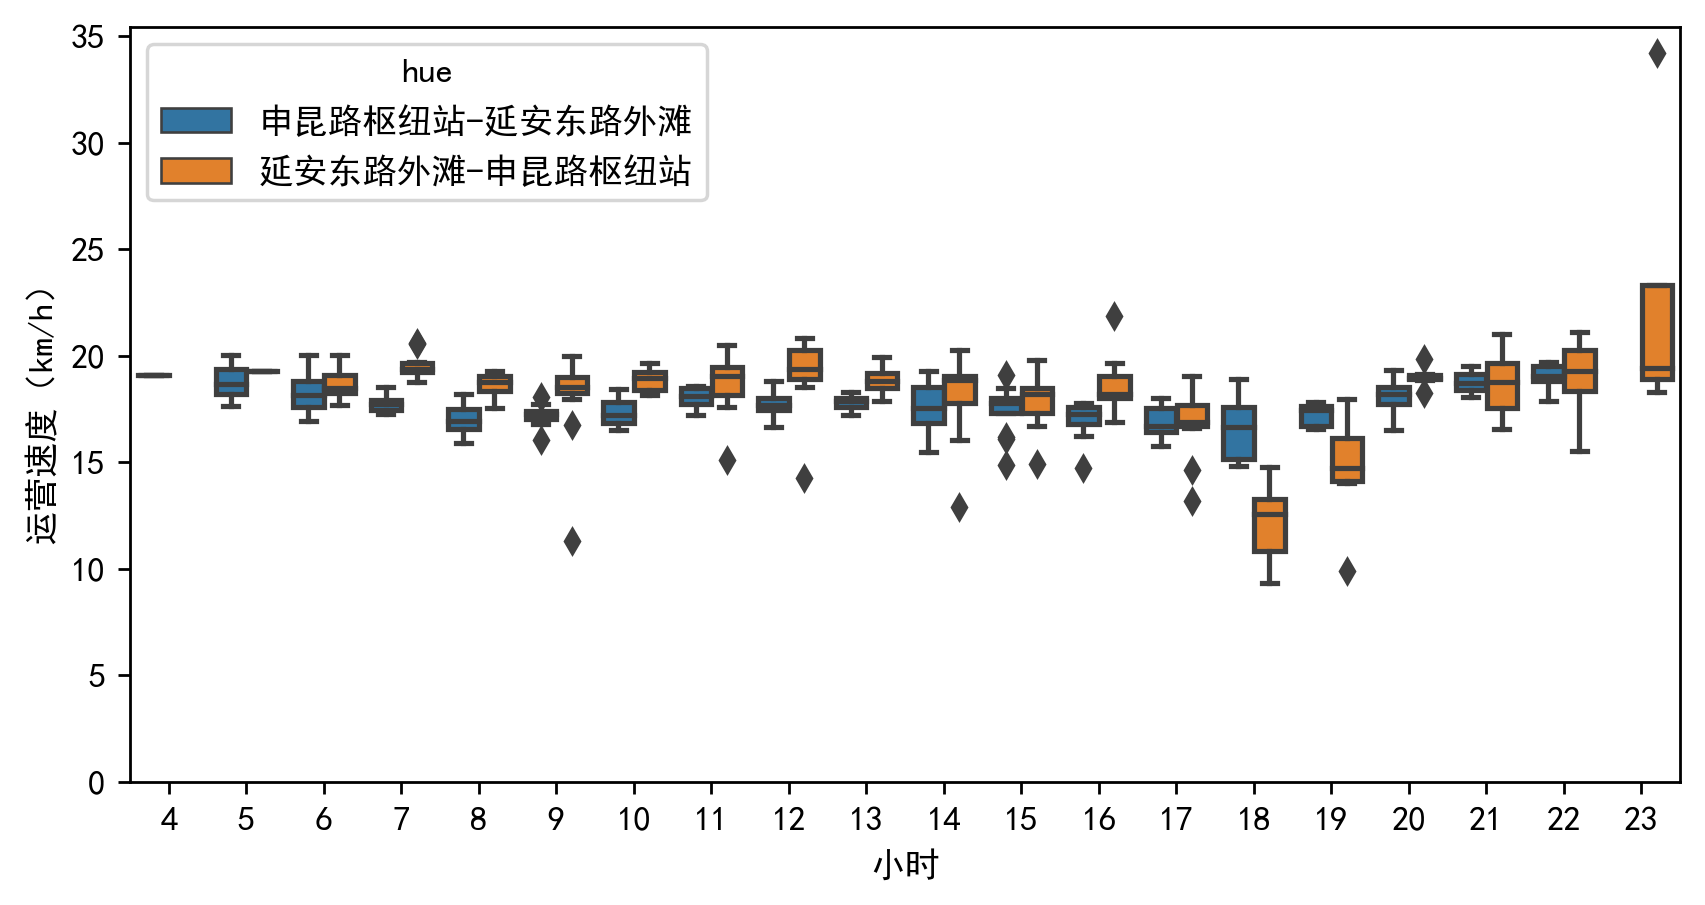

In [13]:
## 车速分布
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig     = plt.figure(1,(8,4),dpi = 250)    
ax1      = plt.subplot(111)

sns.boxplot(x = 'shour',y = 'speed',hue = 'hue',data = c)

plt.ylabel('运营速度（km/h）')
plt.xlabel('小时')
plt.ylim(0)
plt.show()

In [14]:
#到站间隔时间计算

In [18]:
#到站时间间隔需要区分上行1下行，因此在这里要识别上行下行
arrive_info = pd.merge(arrive_info.sort_values(by = ['carid','arrivetime']),stop[['stopname','project']],on ='stopname')
#排序
arrive_info = arrive_info.sort_values(by = ['carid','arrivetime'])
arrive_info['carid1'] = arrive_info['carid'].shift() 
arrive_info['project1'] = arrive_info['project'].shift()
tmp = arrive_info[arrive_info['carid1'] == arrive_info['carid']]
#判断上行还是下行
tmp['ToDir'] = (tmp['project1']>tmp['project']).astype(int)
#对上行计算各站点的到站时间间隔
tmp1 = tmp[tmp['ToDir']==1].sort_values(by = ['stopname','arrivetime'])
tmp1['arrivetime1'] = tmp1['arrivetime'].shift(-1)
tmp1['stopname1'] = tmp1['stopname'].shift(-1)
tmp1 = tmp1[tmp1['stopname1'] == tmp1['stopname']]
tmp1['duration'] = tmp1['arrivetime1'] - tmp1['arrivetime']
tmp1['shour'] = (tmp1['arrivetime']/3600).astype('int')
tmp1.loc[(tmp1['shour'] == 7)|(tmp1['shour'] == 8)|(tmp1['shour'] == 9),'hue'] = '早高峰'
tmp1.loc[(tmp1['shour'] == 18)|(tmp1['shour'] == 19),'hue'] = '晚高峰'
tmp1.loc[-((tmp1['shour'] == 7)|(tmp1['shour'] == 8)|(tmp1['shour'] == 9)|(tmp1['shour'] == 18)|(tmp1['shour'] == 19)),'hue'] = '平峰'

In [19]:
#到站时间间隔箱型图绘制

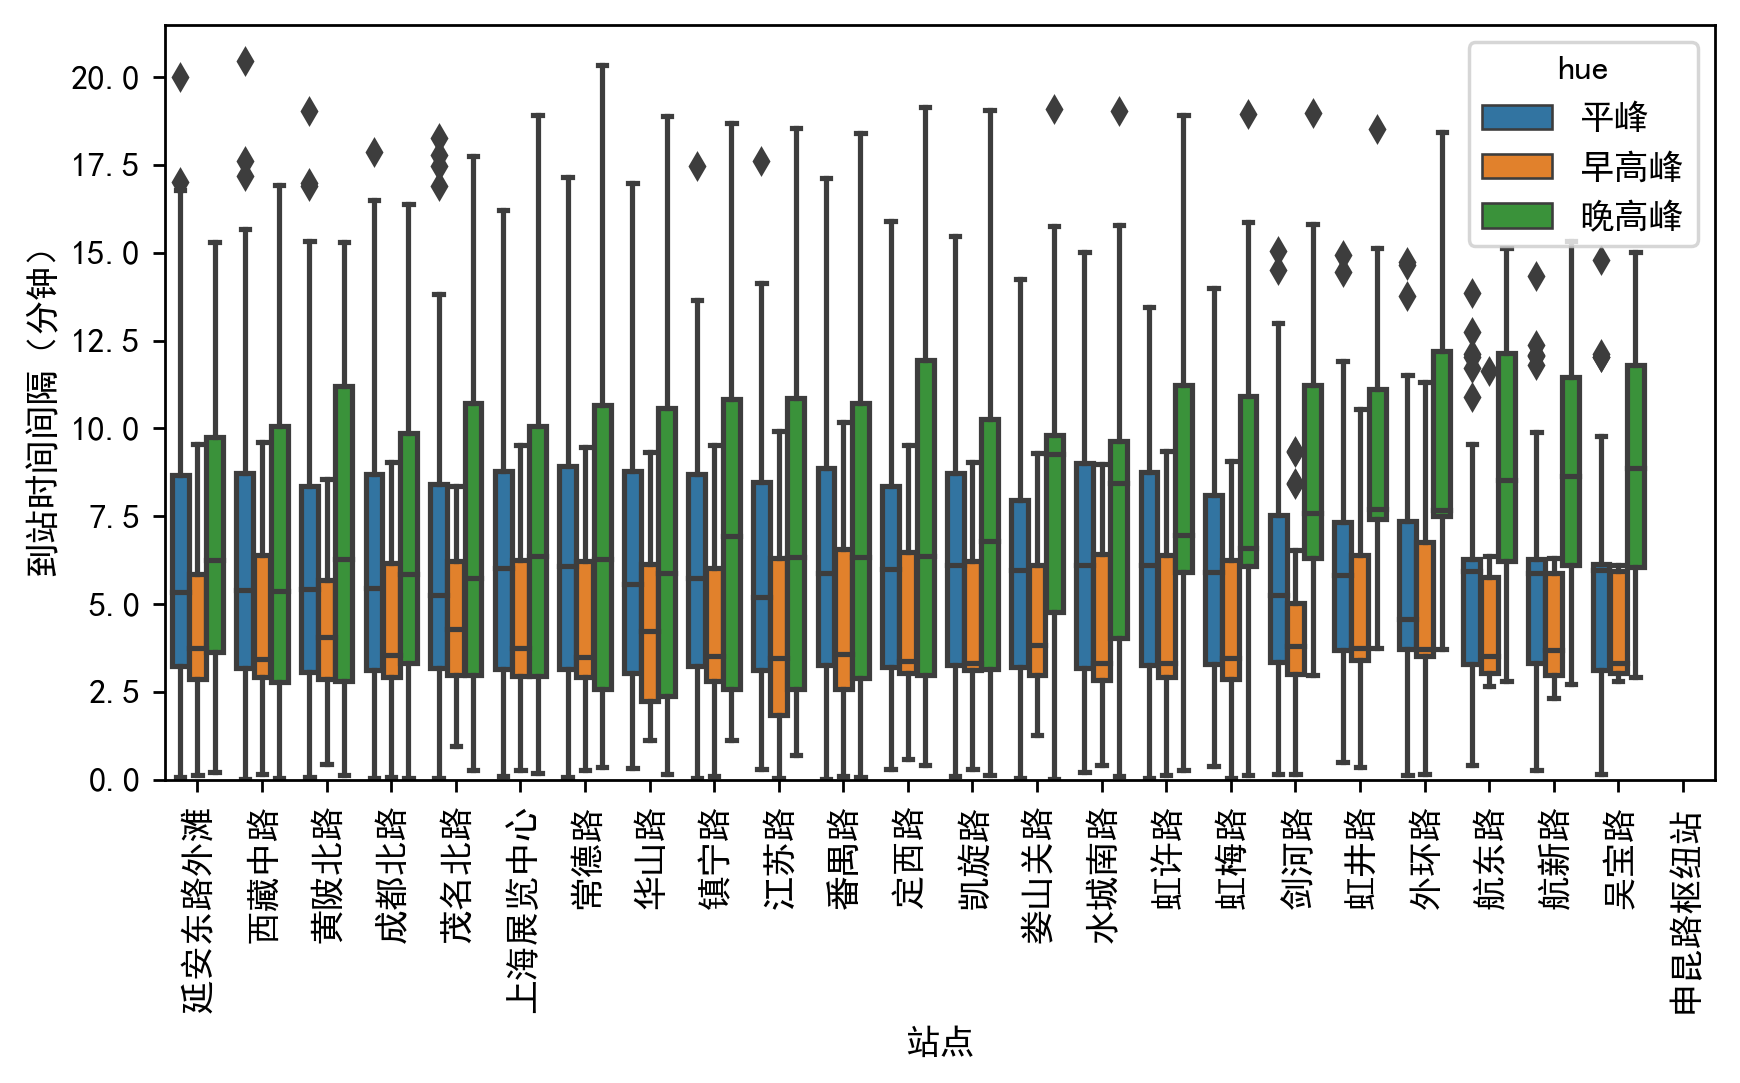

In [20]:
#对上行计算各站点的到站时间间隔
tmp1 = tmp[tmp['ToDir']==1].sort_values(by = ['stopname','arrivetime'])
tmp1['arrivetime1'] = tmp1['arrivetime'].shift(-1)
tmp1['stopname1'] = tmp1['stopname'].shift(-1)
tmp1 = tmp1[tmp1['stopname1'] == tmp1['stopname']]
tmp1['duration'] = tmp1['arrivetime1'] - tmp1['arrivetime']
tmp1['shour'] = (tmp1['arrivetime']/3600).astype('int')
tmp1.loc[(tmp1['shour'] == 7)|(tmp1['shour'] == 8)|(tmp1['shour'] == 9),'hue'] = '早高峰'
tmp1.loc[(tmp1['shour'] == 18)|(tmp1['shour'] == 19),'hue'] = '晚高峰'
tmp1.loc[-((tmp1['shour'] == 7)|(tmp1['shour'] == 8)|(tmp1['shour'] == 9)|(tmp1['shour'] == 18)|(tmp1['shour'] == 19)),'hue'] = '平峰'
#上行的到站时间间隔绘制
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig     = plt.figure(1,(8,4),dpi = 250)    
ax1      = plt.subplot(111)

sns.boxplot(x='stopname',y=tmp1['duration']/60,data = tmp1,hue = 'hue',order = stop['stopname'])

plt.ylabel('到站时间间隔（分钟）')
plt.xlabel('站点')
plt.ylim(0)
plt.xticks(rotation = 90)
plt.show()

In [21]:
#对下行计算各站点的到站时间间隔
tmp1 = tmp[tmp['ToDir']==0].sort_values(by = ['stopname','arrivetime'])
tmp1['arrivetime1'] = tmp1['arrivetime'].shift(-1)
tmp1['stopname1'] = tmp1['stopname'].shift(-1)
tmp1 = tmp1[tmp1['stopname1'] == tmp1['stopname']]
tmp1['duration'] = tmp1['arrivetime1'] - tmp1['arrivetime']
tmp1['shour'] = (tmp1['arrivetime']/3600).astype('int')
tmp1.loc[(tmp1['shour'] == 7)|(tmp1['shour'] == 8)|(tmp1['shour'] == 9),'hue'] = '早高峰'
tmp1.loc[(tmp1['shour'] == 18)|(tmp1['shour'] == 19),'hue'] = '晚高峰'
tmp1.loc[-((tmp1['shour'] == 7)|(tmp1['shour'] == 8)|(tmp1['shour'] == 9)|(tmp1['shour'] == 18)|(tmp1['shour'] == 19)),'hue'] = '平峰'
#到站时间间隔过长的删除
tmp1 = tmp1[tmp1['duration']<20*60]

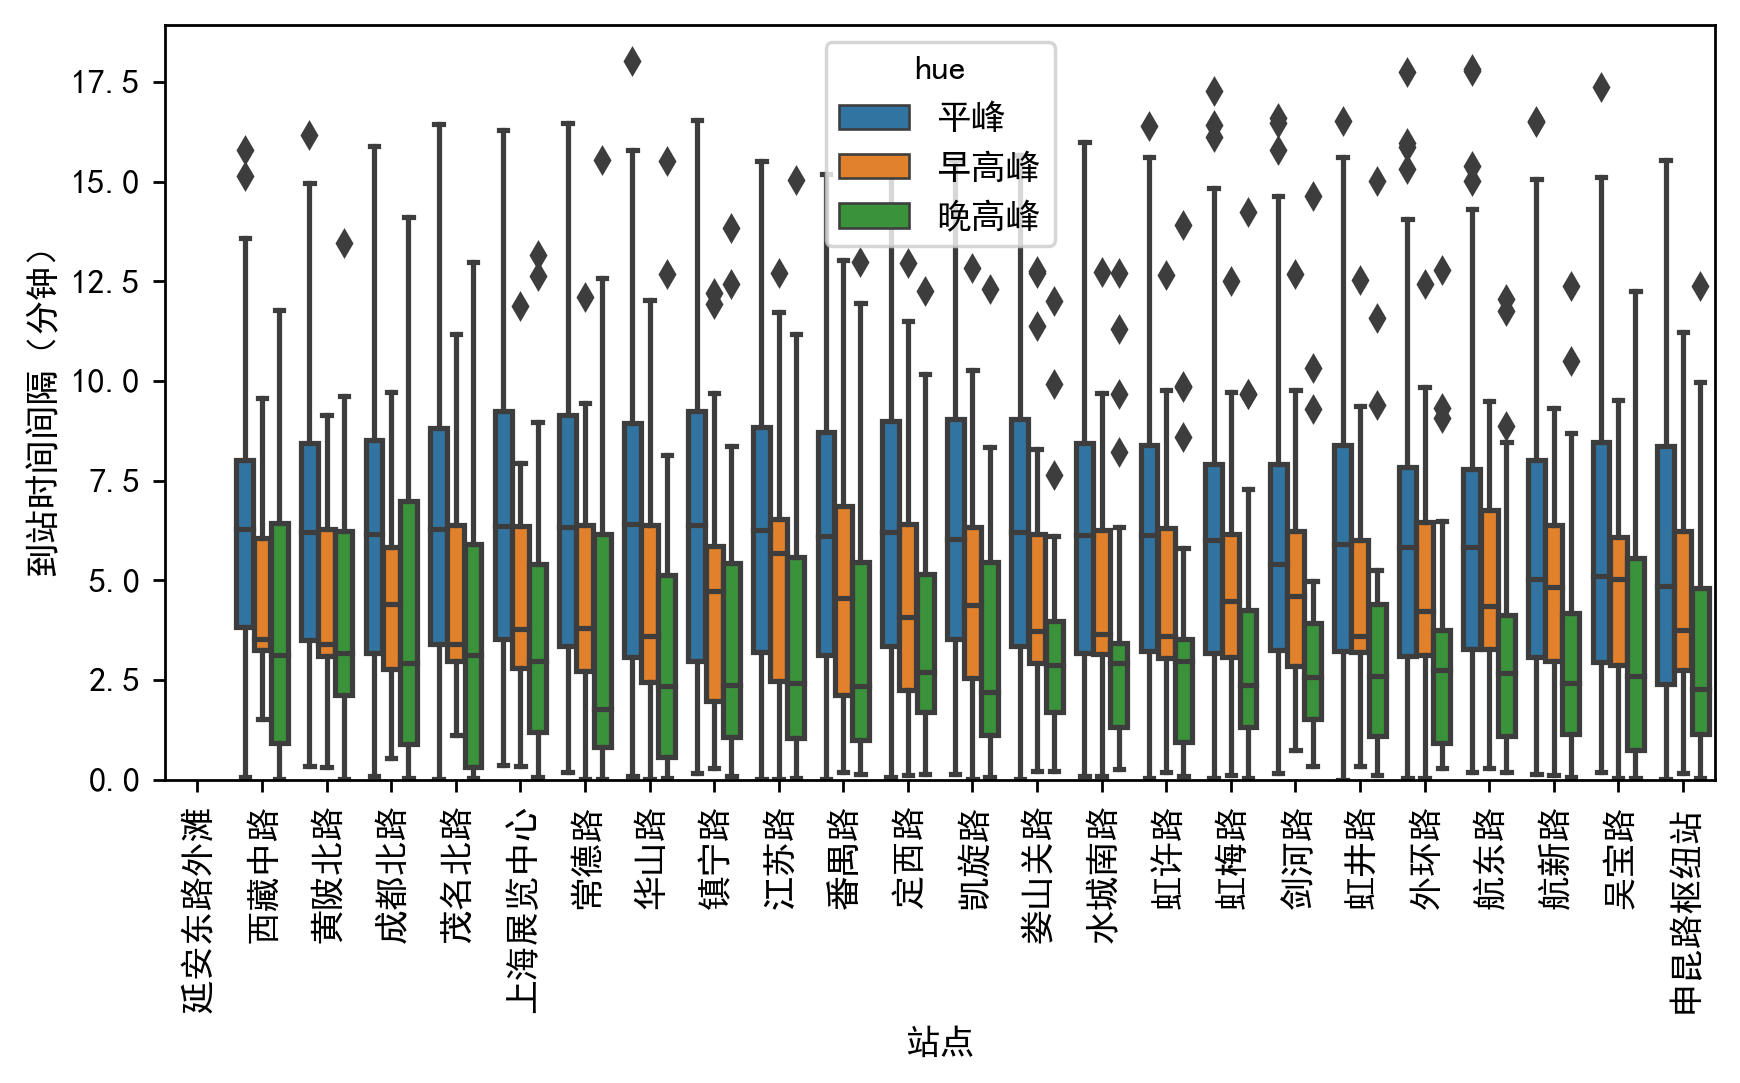

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig     = plt.figure(1,(8,4),dpi = 250)    
ax1      = plt.subplot(111)

sns.boxplot(x='stopname',y=tmp1['duration']/60,data = tmp1,hue = 'hue',order = stop['stopname'])

plt.ylabel('到站时间间隔（分钟）')
plt.xlabel('站点')
plt.ylim(0)
plt.xticks(rotation = 90)
plt.show()